# L3 Fields exploration

#### Imports

In [1]:
import os
import glob
import sys

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw
import optax

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *

import matplotlib
from matplotlib import pyplot as plt


path_L3nadir = '/home/bouxdecl/Documents/data/FIELDS/L3_data/nadirs/al/2023'
path_L3swot  = '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin' 

#path_save_data = './eulerian_dataframes/'
bbox_drifters = [0, 13.5, 36.8, 43.5]
bbox_mediterranea = [-5.8, 36.5, 30, 44.5]

path_save_plot = '../save_plots/save_plots_2024-06-20_L3Fields_exploration'
path_save_data = '../save_data/fields_data'

In [2]:
def plot2d(lon, lat, data, bbox: tuple=bbox_mediterranea, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    gl = ax.gridlines(draw_labels=True, )
    #gl.xlocator = plt.MultipleLocator(1)
    #gl.ylocator = plt.MultipleLocator(1)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

# Nadir L3

In [3]:
# L3 nadir data
drop_var_nadir = ['cycle',
 'track',
 'sla_unfiltered',
 'flag',
 'dac',
 'ocean_tide',
 'internal_tide',
 'lwe',
 'mdt'
 ]

file = os.listdir(path_L3nadir)[0]
ds = xr.open_dataset(os.path.join(path_L3nadir, file)).drop_vars(drop_var_nadir)


In [118]:
ds.sla_filtered

<xarray.DataArray 'sla_filtered' (time: 43986)>
[43986 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2023-06-04T00:00:00.976752128 ... 2023-0...
    longitude  (time) float64 ...
    latitude   (time) float64 ...
Attributes:
    comment:        The sea level anomaly is the sea surface height above mea...
    long_name:      Sea level anomaly filtered not-subsampled with dac, ocean...
    standard_name:  sea_surface_height_above_sea_level
    units:          m

# Swot L3

In [3]:
filtered_files = sorted(glob.glob(os.path.join(path_L3swot, 'SWOT_L3_LR_SSH_Expert_*_003_2023*T*_2023*T*_v0.3.nc')))
filtered_files[:3]

['/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_475_003_20230329T233455_20230330T002600_v0.3.nc',
 '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_476_003_20230330T232532_20230331T001637_v0.3.nc',
 '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_478_003_20230401T230647_20230401T235752_v0.3.nc']

#### create dataset

In [17]:
# create a dataset with all the mediterranean data
drop_var = [
 'mdt',
 'quality_flag',
 'ocean_tide',
 'ssha_noiseless',
 'ssha_unedited',
 'mss',
 'dac',
 'calibration',
 'ugosa',
 'vgosa',
 'sigma0',
 'i_num_line',
 'i_num_pixel',
 'cross_track_distance',
 'duacs_xac',
]


DATAPRODUCT = 'L3SWOT_20240626'
dataset_results = None

first_loop = True
for i, file in enumerate(filtered_files):
    print('processing file {:02d} over {}'.format(i, len(filtered_files)))

    #load domain data
    ds = xr.open_dataset(file, drop_variables=drop_var)
    ds = restrain_domain(ds, *bbox_drifters)
    #ds = ds.dropna(dim='num_lines', how='all', subset=['ssha'])

    #get the average time for this file
    mean_time = get_mean_datetime(ds.time.values)
    time_array = np.array([mean_time], dtype='datetime64[ns]')

    #with the local grid num_lines
    lat_mesh, lon_mesh, ssh = jnp.copy(ds.latitude.values), jnp.copy(ds.longitude.values), jnp.copy(ds.ssha.values)
    mask = jnp.isnan(ssh) 

    u_geos, v_geos = jpw.geostrophy(ssh, lat_mesh, lon_mesh, mask=mask, return_grids=False)
    
    lr_scheduler = optax.exponential_decay(1e-2, 200, .5)  # decrease the learning rate
    optim = optax.sgd(learning_rate=lr_scheduler)  # basic SGD works nicely
    optim = optax.chain(optax.clip(1), optim)  # prevent updates from exploding
    
    u_var, v_var, losses_var = jpw.cyclogeostrophy(ssh, lat_mesh, lon_mesh, mask, optim=optim, return_geos=False, return_grids=False, return_losses=True)

    #save data in formatted dataset

    results_one_time = xr.Dataset(

                                data_vars=dict(
                            
                                    ssh    = (["time", "y", "x"], np.expand_dims(ssh, axis=0)),
                                    u_geos = (["time", "y", "x"], np.expand_dims(u_geos, axis=0)),
                                    v_geos = (["time", "y", "x"], np.expand_dims(v_geos, axis=0)),
                                    
                                    u_var  = (["time", "y", "x"], np.expand_dims(u_var, axis=0)),
                                    v_var  = (["time", "y", "x"], np.expand_dims(v_var, axis=0)),
                                ),
                            
                                coords=dict(
                            
                                    time = time_array,
                                    latitude  = (["y", "x"], lat_mesh),
                                    longitude = (["y", "x"], lon_mesh)
                            
                                ),
                            
                                attrs = dict(
                            
                                    DATAPRODUCT=DATAPRODUCT,
                                    gridtype_adt = 'T grid : (latitude, longitude)',
                                    gridtype_uv  = 'U/V grid'
                                    )
                            )
    
    if first_loop:
        dataset_results = results_one_time
        first_loop = False
    else:
        dataset_results = xr.concat([dataset_results, results_one_time], dim="time")



# --- Save results concatenate in time
dataset_results.to_netcdf(os.path.join(path_save_data, 'results_{}.nc'.format(DATAPRODUCT)))

processing file 00 over 90
processing file 01 over 90
processing file 02 over 90
processing file 03 over 90
processing file 04 over 90
processing file 05 over 90
processing file 06 over 90
processing file 07 over 90
processing file 08 over 90
processing file 09 over 90
processing file 10 over 90
processing file 11 over 90
processing file 12 over 90
processing file 13 over 90
processing file 14 over 90
processing file 15 over 90
processing file 16 over 90
processing file 17 over 90
processing file 18 over 90
processing file 19 over 90
processing file 20 over 90
processing file 21 over 90
processing file 22 over 90
processing file 23 over 90
processing file 24 over 90
processing file 25 over 90
processing file 26 over 90
processing file 27 over 90
processing file 28 over 90
processing file 29 over 90
processing file 30 over 90
processing file 31 over 90
processing file 32 over 90
processing file 33 over 90
processing file 34 over 90
processing file 35 over 90
processing file 36 over 90
p

### Show raw data for one SWOT file
one file = one trip over the mediterranean sea

data saved by the local coord of the satellite 

In [13]:
#data = ds.dropna(dim='num_lines', how='all', subset=['ssha'])
ds = xr.open_dataset(filtered_files[0])
ds = restrain_domain(ds, *bbox_drifters)

ds

<xarray.Dataset>
Dimensions:               (num_lines: 399, num_pixels: 69, num_nadir: 0)
Coordinates:
    latitude              (num_lines, num_pixels) float64 36.8 36.8 ... 43.5
    longitude             (num_lines, num_pixels) float64 2.687 2.709 ... 6.398
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/21)
    time                  (num_lines, num_pixels) datetime64[ns] 2023-03-30T0...
    mdt                   (num_lines, num_pixels) float64 0.0326 nan ... -0.0317
    ssha                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_noiseless        (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_unedited         (num_lines, num_pixels) float64 nan nan ... nan nan
    quality_flag          (num_lines, num_pixels) float32 1.0 nan ... nan 1.0
    ...                    ...
    i_num_line            (num_nadir, num_lines, num_pixels) float32 
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 
    cross_track_distance  (num_pixels, num_lines) float64 -68.0 -68.0 ... 68.0
    duacs_xac             (num_lines, num_pixels) float64 -68.0 nan ... nan 68.0
    longitude_nadir       (num_lines, num_pixels) float64 3.454 nan ... 5.607
    latitude_nadir        (num_lines, num_pixels) float64 36.67 nan ... 43.65
Attributes: (12/41)
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    DUACS - Data Unification and Altimeter C...
    creator_url:                     https://aviso.altimetry.fr
    institution:                     CNES
    license:                         https://www.aviso.altimetry.fr/fileadmin...
    ...                              ...
    time_coverage_begin:             2023-03-29T23:34:55Z
    time_coverage_end:               2023-03-30T00:26:00Z
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              1.5e-05
    geospatial_lon_max:              359.999928

In [11]:
# time span over the mediterranean sea :

np.nanmin(ds.time.values), np.nanmax(ds.time.values)

print('time span (min) = ', float(np.nanmax(ds.time.values)- np.nanmin(ds.time.values)) / (60 *1e9))

time span (min) =  2.0590307157333334


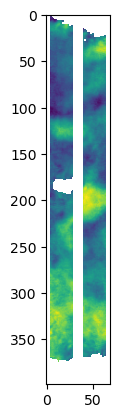

In [6]:
plt.imshow(ds.ssha)

In [7]:
A= ds.where(np.abs(ds.latitude - 38) <= 0.01, drop=True)
A.ssha[5]

<xarray.DataArray 'ssha' (num_pixels: 69)>
array([    nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan, -0.0226, -0.0247, -0.0264, -0.0245, -0.0241,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan])
Coordinates:
    latitude   (num_pixels) float64 38.09 38.09 38.08 ... 37.83 37.83 37.82
    longitude  (num_pixels) float64 3.031 3.053 3.075 ... 4.497 4.519 4.541
Dimensions without coordinates: num_pixels
Attributes:
    long_name:      sea surface height anomaly
    standard_name:  sea_surface_height_above_reference_ellipsoid
    comment:        Height of the sea surface anomaly with all corrections ap...
    units:          m

In [8]:
ds.latitude[0][0].values, ds.latitude[-1][0].values 

(array(36.803074), array(43.800488))

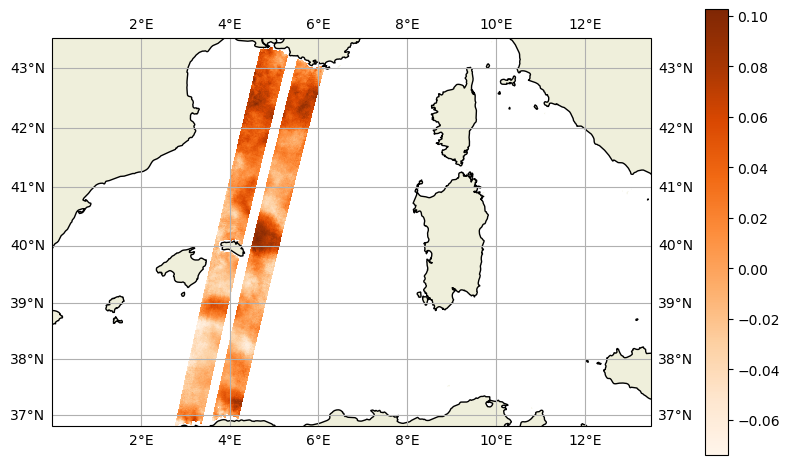

In [9]:
plot2d(ds.longitude, ds.latitude, ds.ssha, bbox=bbox_drifters)

In [62]:

def isin_swath(lat, lon):
    x1, x2, x3, x4, y_down, y_up, x_up = 2.85, 3.42, 3.62, 4.2, 37.14, 43.76, 4.76
    pente = (x_up - x1) / (y_up - y_down) 

    lon_down = lon - pente * (lat - y_down)

    return np.logical_or(np.logical_and(x1 <= lon_down, lon_down <= x2),  np.logical_and(x3 <= lon_down, lon_down <= x4))


isin_swath(np.array([43, 41, 42, 41]), np.array([2, 4, 5, 41]))

array([False,  True, False, False])

In [10]:

# construction de la grille
res = 0.01 #°

min_lat = ds.latitude.min()
max_lat = ds.latitude.max()
min_lon = ds.longitude.min()
max_lon = ds.longitude.max()

grid_lat = xr.DataArray(np.arange(min_lat, max_lat, res), dims='lat')
grid_lon = xr.DataArray(np.arange(min_lon, max_lon, res), dims='lon')

lon_mesh, lat_mesh = np.meshgrid(grid_lon, grid_lat)

data_interpolated = scipy.interpolate.griddata((ds.longitude.values.flatten(), ds.latitude.values.flatten()), ds.ssha.values.flatten(), (lon_mesh, lat_mesh), method='linear')


"\nfrom scipy.interpolate import griddata\n\n# Create meshgrid for regular grid\nlat_mesh, lon_mesh = np.meshgrid(grid_lat, grid_lon)\n\n# Perform 2D interpolation\ndata_interpolated = griddata((lat_nreg, lon_nreg), data_nreg, (lat_mesh, lon_mesh), method='linear')\n\n\n\n# interpolation de la ssh sur cette grille\nds.interp(latitude=grid_lat, longitude=grid_lon, method='linear')\n\n"

In [11]:
data_interpolated.shape

(726, 372)

In [4]:
plot2d(grid_lon, grid_lat,  data_interpolated, bbox=utils.BBOX_SWATH)

NameError: name 'plot2d' is not defined